In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, concatenate
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [3]:
train_data = pd.read_csv('NIFTY_VIX_train.csv')
test_data = pd.read_csv('NIFTY_VIX_test.csv')

features_train = train_data.drop(columns=['date', 'close_NIFTY'])
target_train = train_data['close_NIFTY']
features_test = test_data.drop(columns=['date', 'close_NIFTY'])
target_test = test_data['close_NIFTY']

nifty_open_train = features_train['NIFTY_Open'].values.reshape(-1, 1)
features_train = features_train.drop(columns=['NIFTY_Open'])

nifty_open_test = features_test['NIFTY_Open'].values.reshape(-1, 1)
features_test = features_test.drop(columns=['NIFTY_Open'])

In [4]:
scaler = MinMaxScaler()
features_train_scaled = scaler.fit_transform(features_train)
features_test_scaled = scaler.transform(features_test)

nifty_open_scaler = MinMaxScaler()
nifty_open_train_scaled = nifty_open_scaler.fit_transform(nifty_open_train)
nifty_open_test_scaled = nifty_open_scaler.transform(nifty_open_test)

target_scaler = MinMaxScaler()
target_train_scaled = target_scaler.fit_transform(target_train.values.reshape(-1, 1))
target_test_scaled = target_scaler.transform(target_test.values.reshape(-1, 1))

In [5]:
def create_sequences(features, open_prices, target, sequence_length):
    X, X_open, y = [], [], []
    for i in range(len(features) - sequence_length):
        X.append(features[i:i + sequence_length])
        X_open.append(open_prices[i:i + sequence_length])
        y.append(target[i + sequence_length])
    return np.array(X), np.array(X_open), np.array(y)

sequence_length = 40
X_train, X_open_train, y_train = create_sequences(features_train_scaled, nifty_open_train_scaled, target_train_scaled, sequence_length)
X_test, X_open_test, y_test = create_sequences(features_test_scaled, nifty_open_test_scaled, target_test_scaled, sequence_length)

input_features = Input(shape=(X_train.shape[1], X_train.shape[2]))
input_open = Input(shape=(X_open_train.shape[1], 1))

In [6]:
x1 = LSTM(32, return_sequences=True)(input_features)
x1 = Dropout(0.1)(x1)
x1 = LSTM(32)(x1)
x1 = Dropout(0.1)(x1)
x2 = LSTM(32, return_sequences=True)(input_open)
x2 = Dropout(0.1)(x2)
x2 = LSTM(32)(x2)
x2 = Dropout(0.1)(x2)
merged = concatenate([x1, x2])
output = Dense(1)(merged)


In [7]:
model = Model(inputs=[input_features, input_open], outputs=output)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.002), loss='mse')

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(
    [X_train, X_open_train], y_train,
    epochs=50, batch_size=16,
    validation_data=([X_test, X_open_test], y_test),
    callbacks=[early_stop]
)

loss = model.evaluate([X_test, X_open_test], y_test)
print(f'Test Loss: {loss:.6f}')

Epoch 1/50


/Users/harsh/.local/pipx/venvs/jupyter/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_12', 'keras_tensor_13']. Received: the structure of inputs=('*', '*')
  warnings.warn(


1169/1169 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.0054 - val_loss: 0.0059
Epoch 2/50
1169/1169 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 7.5629e-04 - val_loss: 0.0116
Epoch 3/50
1169/1169 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 5.5746e-04 - val_loss: 0.0052
Epoch 4/50
1169/1169 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 4.1161e-04 - val_loss: 0.0083
Epoch 5/50
1169/1169 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 3.0606e-04 - val_loss: 0.0121
Epoch 6/50
1169/1169 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 3.0867e-04 - val_loss: 0.0098
Epoch 7/50
1169/1169 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 2.6330e-04 - val_loss: 0.0105
Epoch 8/50
1169/1169 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 2.6602e-04 - val_loss: 0.0167
Epoch 9/50
1169/1169 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 2.7075e-04 - val_loss: 0.0132
Epoch 10/50
1169/1169 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 2.6810e-04 - val_loss: 0.0200
Epoch 11/50
1169/1169 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 2.7113e-04 - val_loss: 0.017

146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


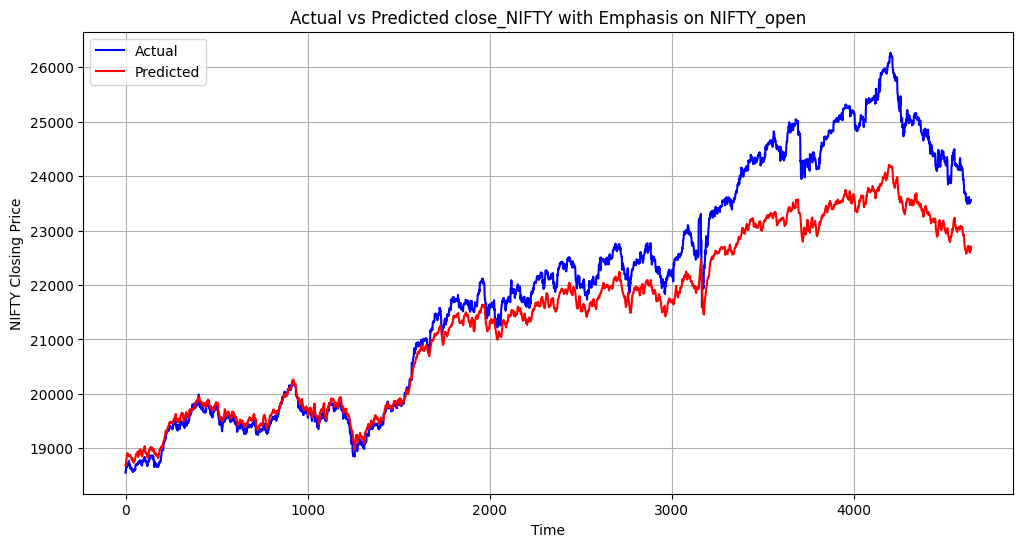

In [8]:
y_pred = model.predict([X_test, X_open_test])

y_pred_denormalized = target_scaler.inverse_transform(y_pred)
y_test_denormalized = target_scaler.inverse_transform(y_test)

plt.figure(figsize=(12, 6))
plt.plot(y_test_denormalized, label='Actual', color='blue')
plt.plot(y_pred_denormalized, label='Predicted', color='red')
plt.legend()
plt.title('Actual vs Predicted close_NIFTY with Emphasis on NIFTY_open')
plt.xlabel('Time')
plt.ylabel('NIFTY Closing Price')
plt.grid(True)
plt.show()